# Exploración de Activos - Históricos Completos (5000 velas)
Notebook diseñada para analizar profundidad, variabilidad, volumen y patrones persistentes por activo.
Cargar desde `D:/trading/data/historic/` los archivos `.parquet` individuales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta

# Configuración global
plt.style.use("ggplot")
%matplotlib inline

DATA_PATH = Path("D:/trading/data/historic")  # ruta local de datos


In [2]:
# Parámetros
simbolo = "DG"  # modificar aquí para explorar otro activo

# Cargar datos
archivo = DATA_PATH / f"{simbolo}.parquet"
df = pd.read_parquet(archivo)

# Asegurar orden y limpieza
df = df.sort_values("fecha").reset_index(drop=True)
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)

print(f"{simbolo}: {df.shape[0]} registros desde {df.index.min().date()} hasta {df.index.max().date()}")
df.tail()


DG: 3911 registros desde 2009-11-13 hasta 2025-06-03


,open,high,low,close,volume
fecha,,,,,
2025-05-28,100.82,100.820000,97.550000,97.77,3157000
2025-05-29,97.65,98.040001,96.140000,97.07,2419800
2025-05-30,96.83,98.160000,96.520000,97.25,5254700
2025-06-02,97.30,98.190000,96.360000,97.17,4878000
2025-06-03,106.96,113.610000,106.080002,112.57,15311400


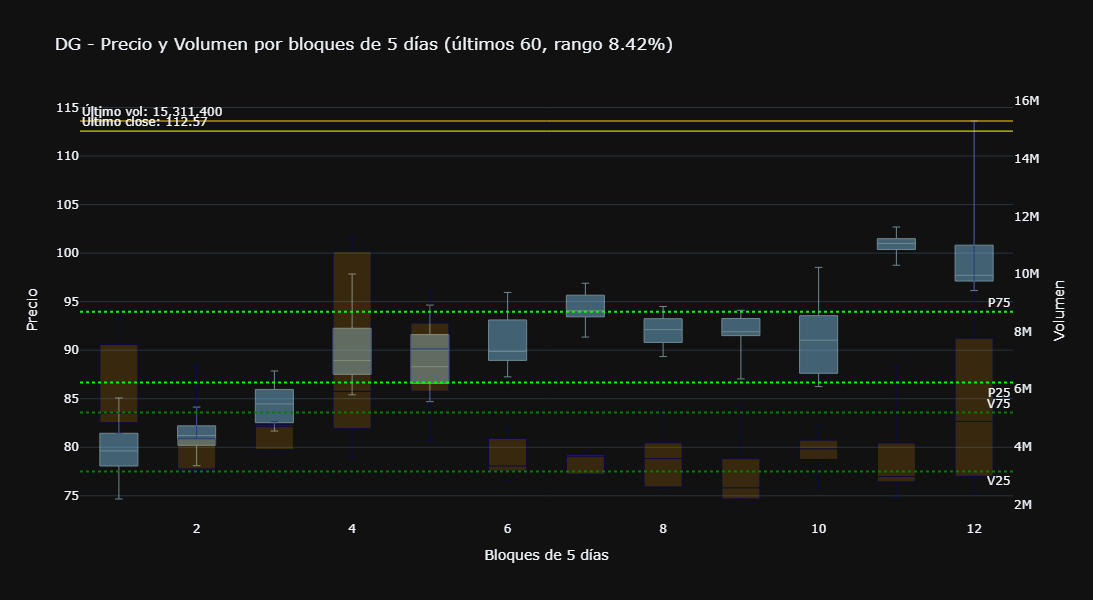

In [3]:
import plotly.graph_objects as go
import numpy as np

# === CONFIGURACIÓN ===
n = 60
d = 5
precio_color = "rgba(135,206,250,0.7)"   # skyblue más saturado
volumen_color = "rgba(255,165,0,0.4)"    # orange claro translúcido

# === PREPARAR DATOS ===
# Precio
df_p = df[["open", "high", "low", "close"]].dropna().tail(n).copy()
df_p["fecha"] = df_p.index
df_p["grupo"] = (np.arange(len(df_p)) // d) + 1
df_box_p = pd.melt(df_p, id_vars=["fecha", "grupo"], value_vars=["open", "high", "low", "close"], var_name="tipo", value_name="precio")

# Volumen
df_v = df[["volume"]].dropna().tail(n).copy()
df_v["fecha"] = df_v.index
df_v["grupo"] = (np.arange(len(df_v)) // d) + 1

# P25/P75/Cierre precio
p25 = df["close"].dropna().tail(n).quantile(0.25)
p75 = df["close"].dropna().tail(n).quantile(0.75)
close_last = df["close"].dropna().iloc[-1]
rango_pct = ((p75 - p25) / p25) * 100

# V25/V75/Cierre volumen
v25 = df["volume"].dropna().tail(n).quantile(0.25)
v75 = df["volume"].dropna().tail(n).quantile(0.75)
vol_last = df["volume"].dropna().iloc[-1]
rango_vol = ((v75 - v25) / v25) * 100

# === GRAFICO ===
fig = go.Figure()

# Boxplots precio
for g in sorted(df_box_p["grupo"].unique()):
    y = df_box_p[df_box_p["grupo"] == g]["precio"]
    fig.add_trace(go.Box(
        y=y,
        x=[g]*len(y),
        name=f"Precio Bloque {g}",
        boxpoints=False,
        line=dict(width=1, color="lightblue"),
        fillcolor=precio_color,
        marker=dict(size=0),
        yaxis="y1",
        opacity=0.6,
        whiskerwidth=0.2
    ))

# Boxplots volumen
for g in sorted(df_v["grupo"].unique()):
    y = df_v[df_v["grupo"] == g]["volume"]
    fig.add_trace(go.Box(
        y=y,
        x=[g]*len(y),
        name=f"Volumen Bloque {g}",
        boxpoints=False,
        line=dict(width=1, color="darkblue"),
        fillcolor=volumen_color,
        marker=dict(size=0),
        yaxis="y2",
        opacity=0.4,
        whiskerwidth=0.2
    ))

# === LÍNEAS REFERENCIA PRECIO (y1) ===
fig.add_hline(y=p25, line_dash="dot", line_color="lime", annotation_text="P25", annotation_position="bottom right", yref="y1")
fig.add_hline(y=p75, line_dash="dot", line_color="lime", annotation_text="P75", annotation_position="top right", yref="y1")
fig.add_hline(y=close_last, line_color="yellow", line_width=1, annotation_text=f"Último close: {close_last:.2f}", annotation_position="top left", yref="y1")

# === LÍNEAS REFERENCIA VOLUMEN (y2) ===
fig.add_hline(y=v25, line_dash="dot", line_color="green", yref="y2", annotation_text="V25", annotation_position="bottom right")
fig.add_hline(y=v75, line_dash="dot", line_color="green", yref="y2", annotation_text="V75", annotation_position="top right")
fig.add_hline(y=vol_last, line_color="gold", line_width=1, yref="y2", annotation_text=f"Último vol: {vol_last:,.0f}", annotation_position="top left")

# === CONFIGURACIÓN FINAL ===
fig.update_layout(
    title=f"{simbolo} - Precio y Volumen por bloques de {d} días (últimos {n}, rango {rango_pct:.2f}%)",
    xaxis_title=f"Bloques de {d} días",
    yaxis=dict(title="Precio", side="left"),
    yaxis2=dict(title="Volumen", overlaying="y", side="right", showgrid=False),
    template="plotly_dark",
    height=600,
    showlegend=False
)

fig.show()


In [4]:
# Cálculo de Z-score para volumen (20 días)
df["vol_mean_20"] = df["volume"].rolling(20).mean()
df["vol_std_20"] = df["volume"].rolling(20).std()
df["vol_zscore"] = (df["volume"] - df["vol_mean_20"]) / df["vol_std_20"]


In [5]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["volume"],
    name="Volumen",
    yaxis="y1",
    line=dict(color="orange")
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["vol_zscore"],
    name="Z-score Volumen",
    yaxis="y2",
    line=dict(color="skyblue", dash="dot")
))

fig.update_layout(
    title=f"{simbolo} - Volumen y Z-score (20 días)",
    template="plotly_dark",
    height=500,
    yaxis=dict(title="Volumen"),
    yaxis2=dict(title="Z-score", overlaying="y", side="right")
)

fig.show()


In [6]:
df["vol_spike"] = df["volume"] > df["vol_mean_20"] * 2.5
spike_count = df["vol_spike"].sum()
print(f"Días con spikes de volumen: {spike_count}")

Días con spikes de volumen: 97


In [7]:
mf_mult = ((df["close"] - df["low"]) - (df["high"] - df["close"])) / (df["high"] - df["low"])
df["AD_line"] = (mf_mult * df["volume"]).fillna(0).cumsum()


In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df["close"], name="Precio", yaxis="y1", line=dict(color="white")))
fig.add_trace(go.Scatter(x=df.index, y=df["AD_line"], name="A/D Line", yaxis="y2", line=dict(color="lime")))

fig.update_layout(
    title=f"{simbolo} - Acumulación/Distribución vs Precio",
    template="plotly_dark",
    height=500,
    yaxis=dict(title="Precio"),
    yaxis2=dict(title="A/D Line", overlaying="y", side="right")
)

fig.show()


In [9]:
df["returns"] = df["close"].pct_change()
df["obv"] = np.where(df["returns"] > 0, df["volume"], -df["volume"])
df["obv"] = df["obv"].fillna(0).cumsum()


In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df["close"], name="Precio", yaxis="y1", line=dict(color="white")))
fig.add_trace(go.Scatter(x=df.index, y=df["obv"], name="OBV", yaxis="y2", line=dict(color="deepskyblue")))

fig.update_layout(
    title=f"{simbolo} - OBV vs Precio",
    template="plotly_dark",
    height=500,
    yaxis=dict(title="Precio"),
    yaxis2=dict(title="OBV", overlaying="y", side="right")
)

fig.show()


In [11]:
df["vol_z_autocorr_1"] = df["vol_zscore"].rolling(20).apply(lambda x: x.autocorr(1))

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["vol_z_autocorr_1"],
    name="Autocorrelación (lag=1)",
    line=dict(color="violet")
))

fig.update_layout(
    title=f"{simbolo} - Persistencia del volumen (autocorrelación de z-score)",
    template="plotly_dark",
    yaxis_title="autocorr(vol_z)",
    height=400
)

fig.show()